1. load geotiff + OSM data



2. explore tiff data structure
3. merge tiff + OSM as 1 image file for transmutation
4. train Diffusion or GAN






In [2]:
import os
os.chdir('../')
os.getcwd()

import glob
import numpy as np
import shutil
from tqdm import tqdm
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from pytorch_fid.fid_score import calculate_fid_given_paths
from random import randrange

import shutil
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
class XYZTileProcessor():
    """load geotiffs and export as XYZ tiles"""
    pass

class ImageProcessor():
    """Loads tiled datasets and generate train and test sets
    input: data layers to indicate experiment setup
    """

    def __init__(self, 
                 conf,
                 dataset_path = 'Datasets/'):
        
        self.conf = conf
        self.citypath = dataset_path + conf['city'] + '/'
        self.layer1 =  self.load_xyz_path(self.citypath + '02Tiles/' + conf['layer1'])
        self.layer2 = self.load_xyz_path(self.citypath + '02Tiles/' + conf['layer2'])
        self.layer3 = self.load_xyz_path(self.citypath + '02Tiles/' + conf['layer3'])
        self.layer4 = self.load_xyz_path(self.citypath + '02Tiles/' + conf['layer4'])

        self.dir_dict = [self.layer1, 
                        self.layer2, 
                        self.layer3, 
                        self.layer4]
        
        self.valid_layers = len([lst for lst in self.dir_dict if len(lst) > 0])
        
        print(f'Valid layers: {self.valid_layers}')
        
        print(f"{str(len(self.layer1))} target {conf['layer1']} files found")

    def load_xyz_path(self, basepath):
        """Load images from slippy map directory"""
        file_list = glob.glob(basepath + '\\*\*\*.png', recursive=True)
        return file_list

    def load_imgs(self):
        """Load images from list of paths"""
        layer1 = Image.open(self.layer1).convert('RGB')
        layer2 = Image.open(self.layer2).convert('RGB')
        layer3 = Image.open(self.layer3).convert('RGB')
        layer4 = Image.open(self.layer4).convert('RGB')
        
        return layer1, layer2, layer3, layer4
    
    def visualize(self, serial=None):
        """Visualize all valid layers"""
        if serial is None:
            serial = randrange(len(self.layer1))
        print('Visualizing serial ' + str(serial))

        def get_path(list, serial):
            return list[serial] if serial < len(list) else None

        img_list = []
        for i in range(self.valid_layers):
            file_path = get_path(self.dir_dict[i], serial)
            img_list.append(Image.open(file_path).convert('RGB'))
        
        fig = plt.figure(figsize=(10., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                        nrows_ncols=(1, self.valid_layers),  # creates 2x2 grid of axes
                        axes_pad=0.1,  # pad between axes in inch.
                        )
        for ax, im in zip(grid, img_list):
            ax.imshow(im)
        plt.show()

    
    def stack_images(self, layer1_path, layer2_path, layer3_path, layer4_path, overlay=True):
        
        def overlay_images(images, alpha=0.8, overlay=overlay):
            if overlay == True:
                blended_image = images[0]
                for image in images[1:]:
                    r, g, b, a = image.split()
                    new_alpha = a.point(lambda x: int(x * alpha))
                    modified_image = Image.merge("RGBA", (r, g, b, new_alpha))
                    blended_image = Image.alpha_composite(blended_image, modified_image)
                return blended_image
            else:
                stacked_image = Image.merge("RGB", images)
                return stacked_image
    
        layer1 = Image.open(layer1_path)
        layer2 = Image.open(layer2_path)
        layer3 = Image.open(layer3_path)
        layer4 = Image.open(layer4_path)
        
        if len(self.conf.get("input_layers")) == 1:
            input_img = eval(self.conf.get("input_layers")[0])
        else:
            img_list = [eval(self.conf.get("input_layers")[0]),
                        eval(self.conf.get("input_layers")[1]),
                        eval(self.conf.get("input_layers")[2])]
            input_img = overlay_images(img_list, alpha=0.8)    
            

        if len(self.conf.get("output_layers")) == 1:
            output_img = eval(self.conf.get("output_layers")[0])
        else:
            img_list = [eval(self.conf.get("output_layers")[0]),
                        eval(self.conf.get("output_layers")[1]),
                        eval(self.conf.get("output_layers")[2])]
            output_img = overlay_images(img_list, alpha=0.8)    
                       
        return input_img, output_img

    def process_images(self, layer1_path, layer2_path, layer3_path, layer4_path, threshold=0.95):
        """Filter out targets with too little pixels and copy the files into Train_A and Train_B folders"""
        
        target_image = Image.open(layer1_path).convert('L')
        empty_pixels = (np.array(target_image) == 0).sum()
        perc_empty = empty_pixels/(target_image.size[0]*target_image.size[1])
        
        if perc_empty < threshold: #remove tiles with too much empty pixels
            input_img, output_img = self.stack_images(layer1_path, layer2_path, layer3_path, layer4_path)
            return input_img, output_img
        
        else:
            return None, None


    def save_train(self, threshold=0.99):
        ### create training set output
        self.output_folder_A = self.citypath + f"03Train/{self.conf['exp_name']}/train_A/"
        self.output_folder_B = self.citypath + f"03Train/{self.conf['exp_name']}/train_B/"
        os.makedirs(self.output_folder_A, exist_ok=True)
        os.makedirs(self.output_folder_B, exist_ok=True)

        # ensure target has flood area
        # check for empty pixels in floodmap, 0 is empty pixel
        
        count = 0
        
        # img_list = []
        # for i in range(self.valid_layers):
        #     valid_lists = self.dir_dict[i]
        #     img_list.append(valid_lists)
        
        for i, group in (enumerate(tqdm(zip(self.layer1, self.layer2, self.layer3, self.layer4), total = len(self.layer1)))):
            layer1_path, layer2_path, layer3_path, layer4_path = group
            
            # check number of missing pixels
            target_image = Image.open(layer4_path).convert('L')
            empty_pixels = (np.array(target_image) == 0).sum()
            perc_empty = empty_pixels/(target_image.size[0]*target_image.size[1])
            
            if perc_empty < threshold: #remove tiles with too much empty pixels
                train_A, train_B = self.stack_images(layer1_path, layer2_path, layer3_path, layer4_path)
                out_path_A = self.output_folder_A + str(i) + '.png'
                out_path_B = self.output_folder_B + str(i) + '.png'
                train_A.save(out_path_A, compress_type=1)
                train_B.save(out_path_B, compress_type=1)
                count += 1
            else:
                continue
        print(str(count) + ' out of ' + str(len(self.layer1)) + ' files processed')

    def save_test(self, threshold=10):
        """only save merged channel images in a separate folder"""
        
        self.test_output_folder = self.citypath + '04Test/'
        
        for i, group in tqdm(enumerate(zip(self.buildings, self.roads, self.LRDTMs, self.DTMs))):
            building, road, LRDTM, DTM = group

            train_A, _, _ = self.process_images(building, road, LRDTM, DTM, threshold)
    
            # make test set from merged images
            test_outpath = self.test_output_folder + building[len(self.citypath) + 13:]
            os.makedirs(os.path.dirname(test_outpath), exist_ok=True)
            train_A.save(test_outpath, compress_type=1)
            
def parse_train_cmd(conf):
    return f"python train.py --name {conf['exp_name']} --dataroot datasets/{conf['city']}/03Train/{conf['exp_name']} --no_instance --batchSize 6"



Valid layers: 4
4020 target Input files found
Visualizing serial 10


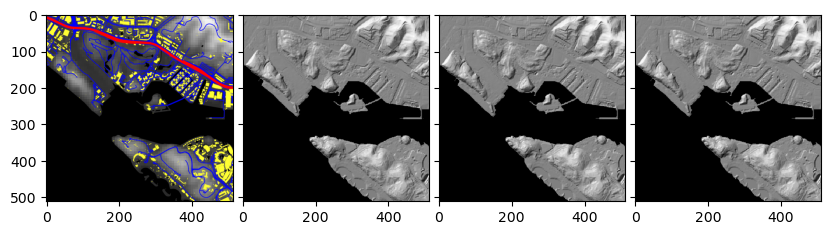

python train.py --name SGTerrain --dataroot datasets/SGTerrain/03Train/SGTerrain --no_instance --batchSize 6


100%|██████████| 4020/4020 [01:17<00:00, 52.18it/s] 

1085 out of 4020 files processed


In [8]:
conf = {'city':'SGTerrain',
        'exp_name':'SGTerrain',
        'layer1':'Input', #
        'layer2':'Output',
        'layer3':'Output',
        'layer4':'Output',
        'input_layers':['layer1' ],
        'output_layers':['layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=10)
print(parse_train_cmd(conf))
ip.save_train(threshold=0.3) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

### Configs for 30m DEMs

Valid layers: 4
7938 target DEM files found
Visualizing serial 1000


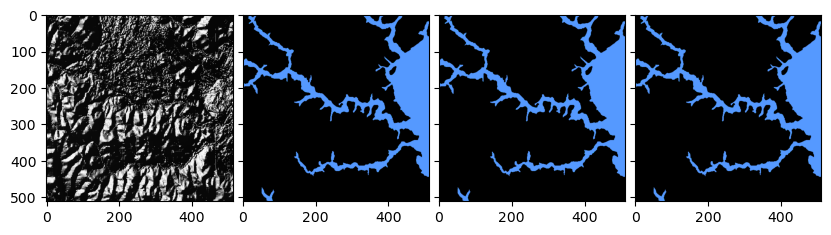

python train.py --name TX30 --dataroot datasets/TX30/03Train/TX30 --no_instance --batchSize 6


100%|██████████| 7938/7938 [09:00<00:00, 14.70it/s]  

6852 out of 7938 files processed


In [10]:
conf = {'city':'TX30',
        'exp_name':'TX30',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=1000)
print(parse_train_cmd(conf))
ip.save_train(threshold=0.99) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

Valid layers: 4
2168 target DEM files found
Visualizing serial 20


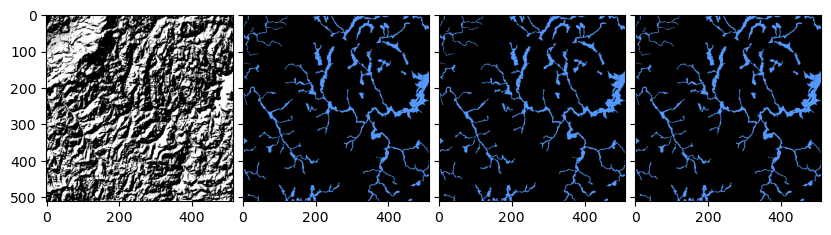

python train.py --name NJ30 --dataroot datasets/NJ30/03Train/NJ30 --no_instance --batchSize 6


100%|██████████| 2168/2168 [01:51<00:00, 19.53it/s]

1966 out of 2168 files processed


In [13]:
conf = {'city':'NJ30',
        'exp_name':'NJ30',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=20)
print(parse_train_cmd(conf))
ip.save_train(threshold=0.985) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

Valid layers: 4
3606 target DEM files found
Visualizing serial 20


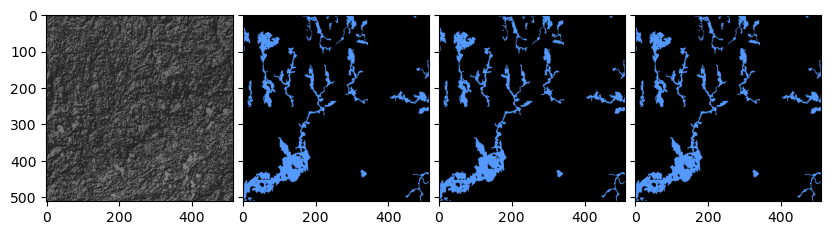

python train.py --name MI30 --dataroot datasets/MI30/03Train/MI30 --no_instance --batchSize 6


100%|██████████| 3606/3606 [02:40<00:00, 22.51it/s]

1980 out of 3606 files processed


In [14]:
conf = {'city':'MI30',
        'exp_name':'MI30',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=20)
print(parse_train_cmd(conf))
ip.save_train(threshold=0.985) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

### Configs for 10m DEMs

Valid layers: 4
3552 target DEM files found
Visualizing serial 7


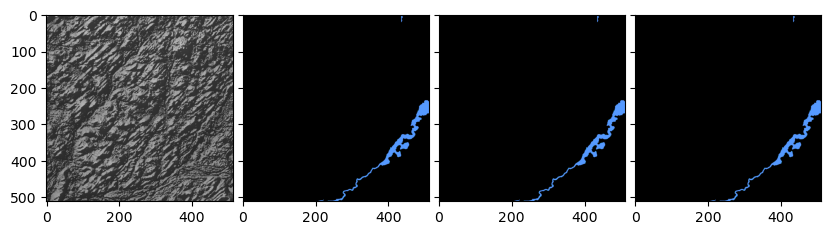

100%|██████████| 3552/3552 [03:51<00:00, 15.37it/s]

2013 out of 3552 files processed


In [7]:
conf = {'city':'MINew',
        'exp_name':'MINew',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1'],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=7)
ip.save_train(threshold=0.99) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

Valid layers: 4
3552 target DEM files found
Visualizing serial 7


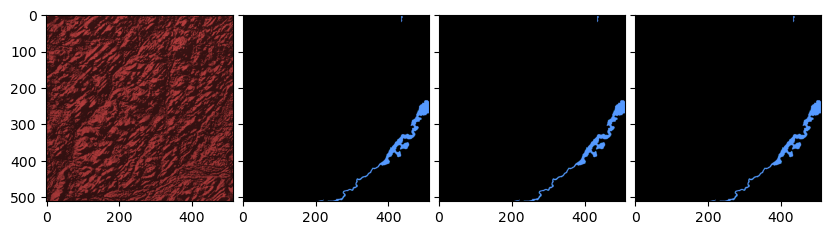

100%|██████████| 3552/3552 [03:21<00:00, 17.64it/s]

2013 out of 3552 files processed


In [6]:
conf = {'city':'MIRed',
        'exp_name':'MIRed',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1'],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=7)
ip.save_train(threshold=0.99) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

In [5]:
parse_train_cmd(conf)

'python train.py --name MIHill --dataroot datasets/MIHill/03Train/MIHill --no_instance --batchSize 6'

In [ ]:
python train.py --name MINew --dataroot datasets/MINew/03Train/MINew --no_instance --batchSize 6 --continue_train

In [ ]:
# test template
python test.py --name MInew --dataroot ./datasets/MINew/04Test/NewRegion --no_instance

Valid layers: 4
7890 target DEM files found
Visualizing serial 7


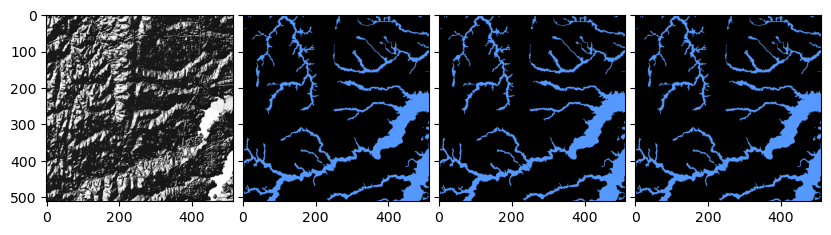

100%|██████████| 7890/7890 [11:54<00:00, 11.04it/s]

6793 out of 7890 files processed


In [6]:
conf = {'city':'TXNew',
        'exp_name':'TXNew',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=7)
ip.save_train(threshold=0.99) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

In [7]:
parse_train_cmd(conf)

'python train.py --name TX_New --dataroot datasets/TexasNew/03Train/TX_New --no_instance --batchSize 6'

Valid layers: 4
2132 target DEM files found
Visualizing serial 20


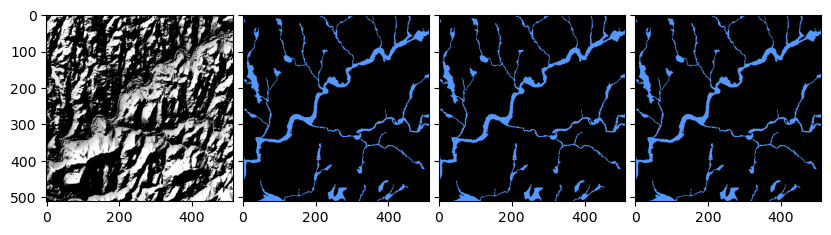

100%|██████████| 2132/2132 [02:52<00:00, 12.33it/s]

1985 out of 2132 files processed


In [11]:
conf = {'city':'NJNew',
        'exp_name':'NJNew',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=20)
ip.save_train(threshold=0.99) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

Valid layers: 4
2744 target DEM files found
Visualizing serial 20


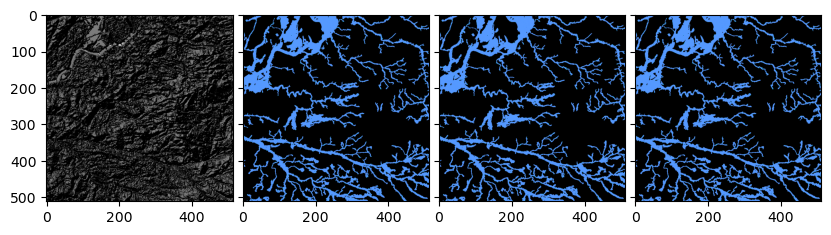

100%|██████████| 2744/2744 [02:47<00:00, 16.40it/s]

2271 out of 2744 files processed


In [4]:
conf = {'city':'NJExp2',
        'exp_name':'NJExp2',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1' ],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=20)
ip.save_train(threshold=0.985) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3

In [5]:
parse_train_cmd(conf)

'python train.py --name NJExp2 --dataroot datasets/NJExp2/03Train/NJExp2 --no_instance --batchSize 6'

In [ ]:
python train.py --name NJExp2 --dataroot datasets/NJExp2/03Train/NJExp2 --no_instance --batchSize 6

In [ ]:
# test template
python test.py --name MI30 --dataroot ./datasets/MI30/02Tiles/DEM --no_instance & wait;
python test.py --name NJ30 --dataroot ./datasets/NJ30/02Tiles/DEM --no_instance & wait;
python test.py --name TX30 --dataroot ./datasets/TX30/02Tiles/DEM --no_instance

### National Experiment configs

Valid layers: 4
334479 target DEM files found
Visualizing serial 100


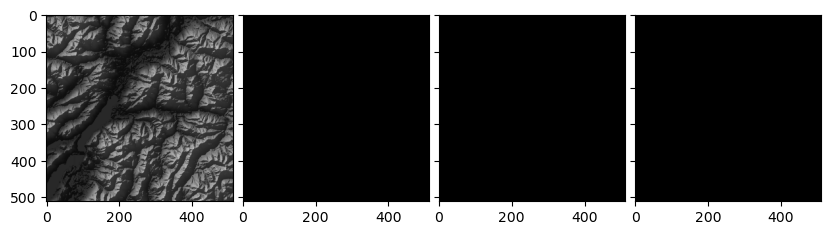

100%|██████████| 334479/334479 [2:47:31<00:00, 33.28it/s]  

89322 out of 334479 files processed


In [3]:
conf = {'city':'USA',
        'exp_name':'USA',
        'layer1':'DEM', #
        'layer2':'Flood',
        'layer3':'Flood',
        'layer4':'Flood',
        'input_layers':['layer1'],
        'output_layers':['layer1', 'layer2', 'layer2'],
        'threshold_layer': 'layer4', # layer to check for empty pixels
        'threshold_type':'empty_pixels', # empty_pixels or flood_area
}

ip = ImageProcessor(conf)

ip.visualize(serial=100)
ip.save_train(threshold=0.985) # if keep tiles with flood, use 0.99, if want to keep all dem areas, use 0.3